## System Settings

### Working Directory Setting

In [78]:
import os


# Set the current working directory
os.chdir("/content/drive/MyDrive/fact-checker")
print(os.getcwd())

/content/drive/MyDrive/fact-checker


### GPU Activation

In [79]:
import torch


# Activate the GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and enabled.")
else:
    device = torch.device("cpu")
    print("GPU is not available. CPU is being used.")

GPU is available and enabled.


## Preprocessing

### Concatenation

In [80]:
import json

# Map string labels onto numerical labels
label_map = {
    "REFUTES": 0,
    "SUPPORTS": 1,
    "DISPUTED": 2,
    "NOT_ENOUGH_INFO": 3,
}

# Concatenate a claim with its evidence
def concat_claim_evidence(claim_path, evidence_path="data/evidence.json"):
    ids = []
    texts = []
    labels = []

    # Load the evidence file
    with open(evidence_path, "r") as e:
        evidence_data = json.load(e)

    # Load the claim file
    with open(claim_path, "r") as c:
        claim_data = json.load(c)

        for claim_key, claim_val in claim_data.items():
            ids.append(claim_key)
            evidence_ids = (claim_val["evidences"])
            labels.append(label_map[claim_val["claim_label"]])

            # Concatenate a claim with its evidence
            text = "[CLS] " + claim_val["claim_text"] + " [SEP] "
            for evidence_id in evidence_ids:
                text += evidence_data[evidence_id] + " [SEP] "
            texts.append(text)

    return ids, texts, labels,


# Standardize the training data
train_data_path = "data/train-claims.json"
train_ids, train_texts, train_labels = concat_claim_evidence(train_data_path)
train_labels_tensor = torch.tensor(train_labels)

# Standardize the development data
dev_data_path = "data/dev-claims.json"
dev_ids, dev_texts, dev_labels = concat_claim_evidence(dev_data_path)
dev_labels_tensor = torch.tensor(dev_labels)

### Encoding

In [81]:
from transformers import BertModel, BertTokenizer


bert_model_name = "bert-base-uncased"

# Tokenize and encode the texts
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)
dev_encodings = tokenizer(
    dev_texts,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)

### Tensor Dataset and Data Loader Creation

In [82]:
from torch.utils.data import DataLoader, TensorDataset


# Create DataLoaders for batching
train_dataset = TensorDataset(
    train_encodings["input_ids"],
    train_encodings["attention_mask"],
    torch.tensor(train_labels)
)
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True
)

dev_dataset = TensorDataset(
    dev_encodings["input_ids"],
    dev_encodings["attention_mask"],
    torch.tensor(dev_labels)
)
dev_loader = DataLoader(
    dev_dataset,
    batch_size=16,
    shuffle=False
)

## Training

### Neural Network Implementation

In [83]:
import torch.nn as nn
import torch.optim as optim


# Define a classifier using BERT
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes, dropout_prob=0.3):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        return self.fc(x)


# Initialize the classifier
num_classes = 4
classifier = BERTClassifier(bert_model_name, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=2e-5)

### Training

In [84]:
epochs = 10
for epoch in range(epochs):
    classifier.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = classifier(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}")

Epoch 1/10, Loss: 1.2875462801425488
Epoch 2/10, Loss: 1.2004851435686086
Epoch 3/10, Loss: 0.9796171312208299
Epoch 4/10, Loss: 0.7114652824866308
Epoch 5/10, Loss: 0.44251944840728463
Epoch 6/10, Loss: 0.2555160899828007
Epoch 7/10, Loss: 0.17438264943465784
Epoch 8/10, Loss: 0.0923474689510155
Epoch 9/10, Loss: 0.07862900562777922
Epoch 10/10, Loss: 0.043048426146050554


## Evaluation

### Accuracy and F1

In [85]:
from sklearn.metrics import accuracy_score, f1_score


classifier.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in dev_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = classifier(input_ids, attention_mask)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average="weighted")
print(f"Validation accuracy: {accuracy}")
print(f"Validation F1 score: {f1}")

Validation accuracy: 0.4935064935064935
Validation F1 score: 0.4623716323917531


### Visualization

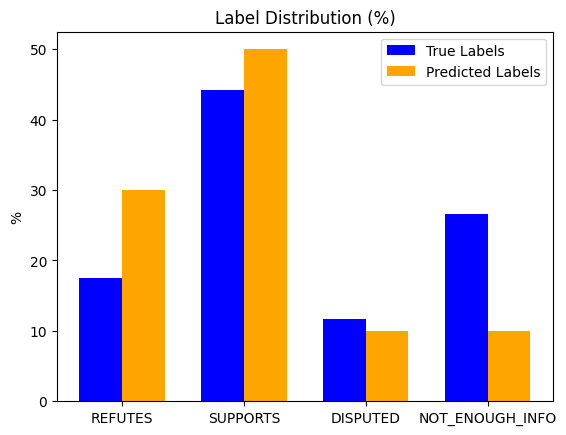

In [86]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Convert tensors to numpy arrays
true_labels = dev_labels_tensor.cpu().numpy()
predicted_labels = predicted.cpu().numpy()

# Calculate the label distribution for true labels
true_label_counts = Counter(true_labels)
total_true = sum(true_label_counts.values())
true_label_percentage = [
    (true_label_counts[i] / total_true) * 100 for i in range(len(label_map))
]

# Calculate the label distribution for predicted labels
predicted_label_counts = Counter(predicted_labels)
total_predicted = sum(predicted_label_counts.values())
predicted_label_percentage = [
    (predicted_label_counts[i] / total_predicted) * 100 for i in range(len(label_map))
]

# Set the plot parameters
labels = list(label_map.keys())
x = np.arange(len(labels))
width = 0.35

# Create the plot
fig, ax = plt.subplots()
ax.bar(
    x - width/2,
    true_label_percentage,
    width,
    label="True Labels",
    color="blue"
)
ax.bar(
    x + width/2,
    predicted_label_percentage,
    width,
    label="Predicted Labels",
    color="orange"
)

# Customize the plot
ax.set_ylabel("%")
ax.set_title("Label Distribution (%)")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.show()